In [1]:
scores = '../out/ko_scores.txt'
cofile = '../out/sorted_conditions.txt'
colfile = '../out/sorted_conditions.linkage.gz'

In [2]:
# plotting imports
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

sns.set_style('white')

plt.rc('font', size=12)

In [3]:
# other imports
import random
import itertools
import numpy as np
import pandas as pd
from scipy import cluster
import fastcluster as fst
import matplotlib.patches as patches

In [4]:
m = pd.read_table(scores, index_col=[0, 2]).sort_index()
m['phenotype'] = m['qvalue'] < 0.05
m['pos-phenotype'] = (m['qvalue'] < 0.05) & (m['score'] > 0)
m['neg-phenotype'] = (m['qvalue'] < 0.05) & (m['score'] < 0)
genes = None
for s in {x[0] for x in m.index}:
    gs = {x for x in m.loc[s].index}
    if genes is None:
        genes = gs
    else:
        genes = genes.intersection(gs)
genes = sorted(genes)
m = m.loc[(slice(None), genes),]
p = m.pivot_table(index=['strain', 'gene'],
                  columns='condition',
                  values='score')

In [5]:
c = p.copy(deep=True)
c[np.isnan(c)] = 0.
rl = fst.linkage(c, method='average')
cl = fst.linkage(c.T, method='average')
cmap = sns.diverging_palette(76, 217, l=89, n=100, center="dark", as_cmap=True)
cmap.set_bad(sns.xkcd_rgb['grey'], alpha=0.55)

In [6]:
strains = ['S288C', 'Y55',
           'UWOP', 'YPS']
cstrains = {x: c
            for x, c in zip(strains, sns.color_palette('Set1', len(strains)))}

In [7]:
cstrains

{'S288C': (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 'Y55': (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 'UWOP': (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 'YPS': (0.596078431372549, 0.3058823529411765, 0.6392156862745098)}

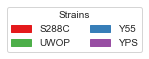

In [8]:
plt.figure(figsize=(2, 0.5))

handles = []
for k, v in sorted(cstrains.items(), key=lambda x: x[0]):
    handles.append(patches.Patch(color=v, label=k))

plt.legend(handles=handles, ncol=int(len(handles)/2),
           loc='center',
           title='Strains')
plt.yticks([])
plt.xticks([])
sns.despine(left=True,
            bottom=True)
plt.savefig('strains_legend.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('strains_legend.svg',
            dpi=300, bbox_inches='tight',
            transparent=True)

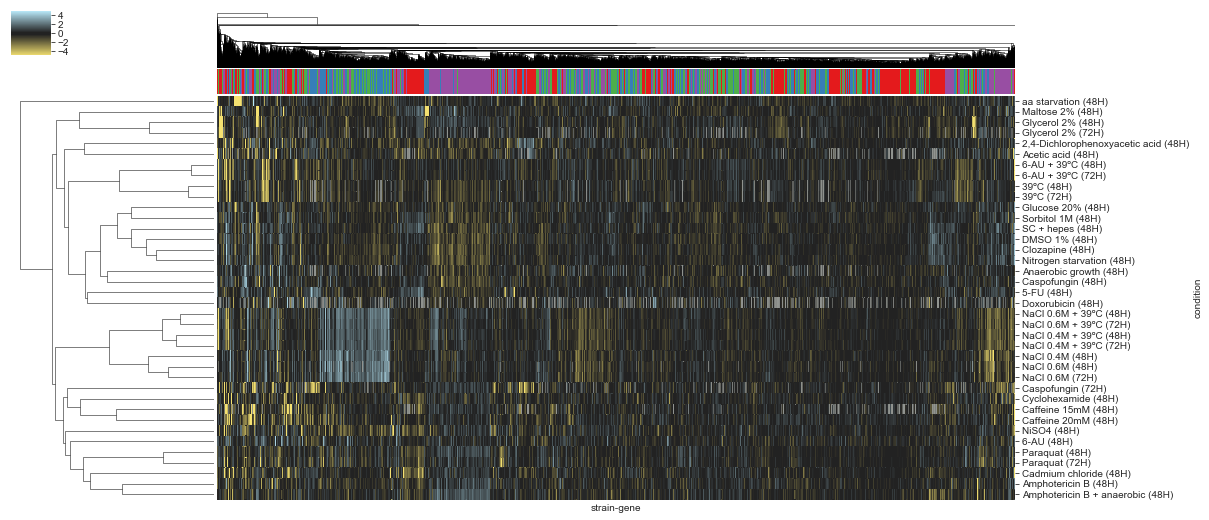

In [9]:
mclust = sns.clustermap(p.T,
                        cmap=cmap,
                        vmax=5,
                        vmin=-5,
                        xticklabels=False,
                        yticklabels=True,
                        row_linkage=cl,
                        col_linkage=rl,
                        figsize=(18, 9),
                        col_colors=[cstrains[x[0]]
                                    for x in p.index]);

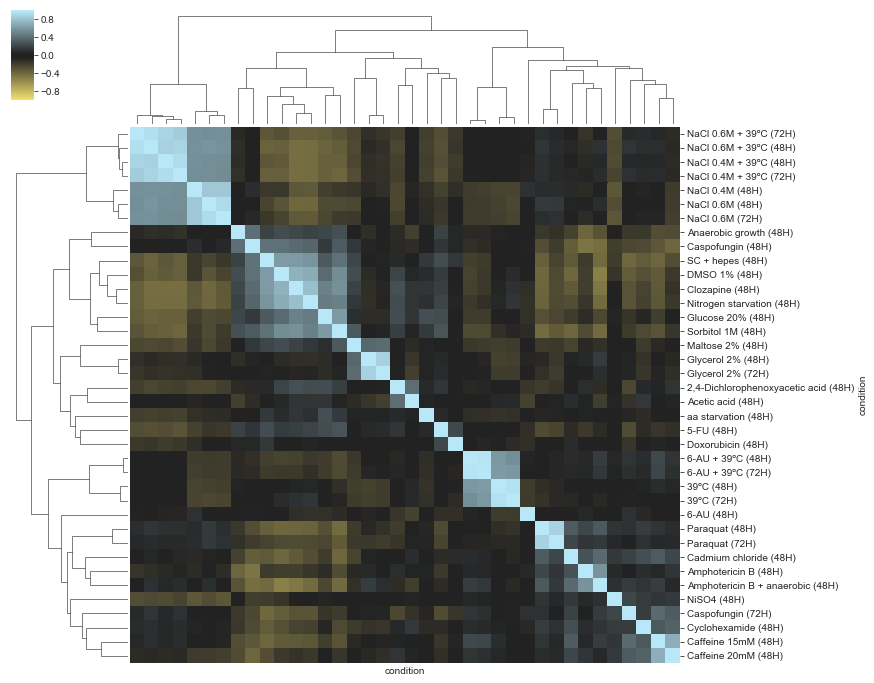

In [10]:
mclust = sns.clustermap(p.corr(),
                        cmap=cmap,
                        vmax=1,
                        vmin=-1,
                        xticklabels=False,
                        yticklabels=True,
                        figsize=(12, 12));

In [11]:
t = []
color1 = []
scolors = []
co = [x.rstrip() for x in open(cofile)]
clinkage = np.loadtxt(colfile)
for i, strain in enumerate(strains):
    color = []
    c = p.loc[strain].copy(deep=True)
    c[np.isnan(c)] = 0.
    rl = fst.linkage(c, method='average')
    rd = cluster.hierarchy.dendrogram(rl, no_plot=True,
                                      color_threshold=-np.inf)
    ro = p.loc[strain].index[rd['leaves']]
    if co is None:
        cl = fst.linkage(c.T, method='average')
        cd = cluster.hierarchy.dendrogram(cl, no_plot=True,
                                          color_threshold=-np.inf)
        co = p.loc[strain].columns[cd['leaves']]
    t.append(p.loc[(strain, ro), co])
    for x in range(p.loc[(strain, ro),].shape[0]):
        color.append(i)
        color1.append(cstrains[strain])
    scolors.append(np.array(color))
t = pd.concat(t)
color = np.array(color)

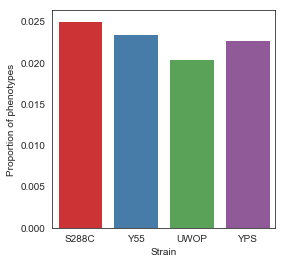

In [12]:
plt.figure(figsize=(4, 4))

df = m.reset_index().set_index('gene').loc[
     genes].groupby('strain').sum()['phenotype'
     ] / m.reset_index().set_index('gene').loc[
     genes].groupby('strain').count()['phenotype']
df = df.reset_index()
sns.barplot(data=df, x='strain', y='phenotype',
            order=strains,
            palette=[cstrains[x]
                     for x in strains])

plt.xlabel('Strain')
plt.ylabel('Proportion of phenotypes');

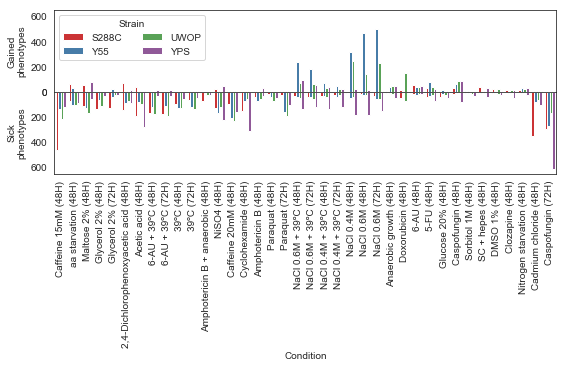

In [13]:
plt.figure(figsize=(9, 3))

for i, tag in enumerate(['pos', 'neg']):
    plt.subplot(2, 1, i+1)

    df = m.reset_index().set_index('gene').loc[
         genes].groupby(['strain',
                         'condition']).sum()['%s-phenotype' % tag
         ]# / m.reset_index().set_index('gene').loc[
         #genes].groupby(['strain',
         #                'condition']).count()['%s-phenotype' % tag]
    df = df.reset_index().rename(columns={'strain': 'Strain'})
    sns.barplot(data=df, hue='Strain', y='%s-phenotype' % tag,
                x='condition',
                hue_order=strains,
                palette=[cstrains[x]
                         for x in strains],
                order=co)

    plt.ylim(0, 650)
    if i == 0:
        plt.xlabel('')
        plt.xticks([])
        plt.ylabel('Gained\nphenotypes')
        plt.legend(loc='upper left',
                   title='Strain',
                   ncol=2)
    else:
        plt.xlabel('Condition')
        plt.ylabel('Sick\nphenotypes')

        plt.xticks(rotation=90)
        
        plt.gca().invert_yaxis()
        plt.gca().legend().remove()

plt.subplots_adjust(hspace=0)

plt.savefig('phenotypes_strains.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('phenotypes_strains.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [14]:
[(strain, cstrains[strain])
 for strain in strains]

[('S288C', (0.8941176470588236, 0.10196078431372549, 0.10980392156862745)),
 ('Y55', (0.21568627450980393, 0.49411764705882355, 0.7215686274509804)),
 ('UWOP', (0.30196078431372547, 0.6862745098039216, 0.2901960784313726)),
 ('YPS', (0.596078431372549, 0.3058823529411765, 0.6392156862745098))]

In [15]:
cmap1 = colors.ListedColormap([cstrains[strain]
                               for strain in strains])

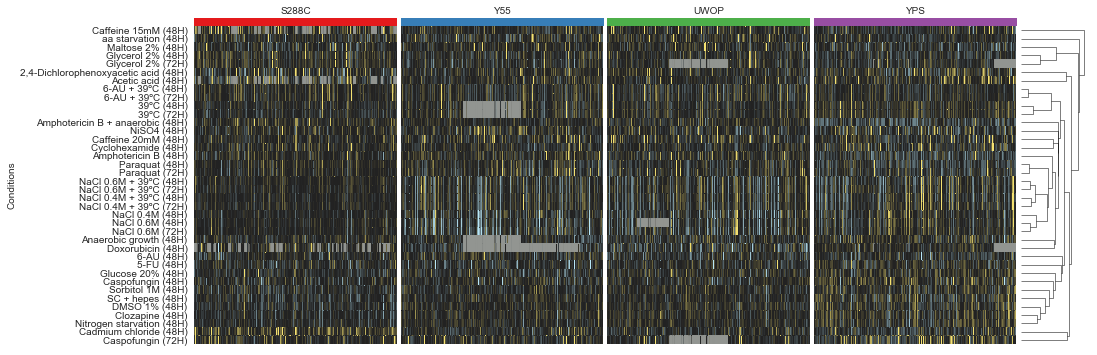

In [16]:
plt.figure(figsize=(16, 6))

gs = plt.GridSpec(2, 5,
                  hspace=0,
                  wspace=0.025,
                  height_ratios=[0.15, 6],
                  width_ratios=[2, 2, 2, 2, 0.66])

ax3 = plt.subplot(gs[9])

for j, i, strain in zip(range(4),
                        range(5, 9),
                        strains):
    ax2 = plt.subplot(gs[i])
    plt.sca(ax2)
    if i == 5:
        yticklabels = True
    else:
        yticklabels = False
    hm = sns.heatmap(t.T[strain],
                     cmap=cmap,
                     vmax=4,
                     vmin=-4,
                     yticklabels=yticklabels,
                     xticklabels=False,
                     cbar=False)
    plt.xlabel('')
    ax2.collections[0].set_rasterized(True)
    if i == 5:
        plt.ylabel('Conditions')
        plt.yticks(rotation=0)
    else:
        plt.ylabel('')
    # cbar_ax = plt.gcf().axes[-1]
    # cbar_ax.set_xlabel('S-score', rotation=270, labelpad=10)

    ax1 = plt.subplot(gs[j])
    plt.sca(ax1)
    plt.imshow(scolors[j].reshape(1, -1),
               aspect='auto',
               cmap=cmap1,
               vmin=0,
               vmax=3)
    plt.yticks([])
    plt.xticks([])
    plt.xlabel('')
    sns.despine(left=True,
                bottom=True)
    plt.xlabel(strain)
    plt.gca().xaxis.set_label_position('top')

plt.sca(ax3)
with plt.rc_context({'lines.linewidth': 0.5}):
    cluster.hierarchy.dendrogram(clinkage, no_plot=False,
                                 color_threshold=-np.inf,
                                 above_threshold_color='k',
                                 orientation='right',
                                 no_labels=True)
plt.xticks([])
plt.gca().invert_yaxis()

sns.despine(bottom=True,
            left=True);

plt.savefig('heatmap.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('heatmap.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

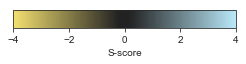

In [17]:
plt.figure(figsize=(4, 0.33))

plt.colorbar(hm.get_children()[0], orientation='horizontal', cax=plt.gca())

plt.xlabel('S-score')

sns.despine(bottom=True,
            left=True,
           ax=plt.gca())

plt.savefig('heatmap_cbar.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('heatmap_cbar.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);